In [178]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# I. Load and Clean Data

In [179]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement_df = pd.read_csv('takehome_user_engagement.csv')

users_df.shape, engagement_df.shape

((12000, 10), (207917, 3))

In [180]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [181]:
# Ensure length of user table matches with the number of unique user ids

len(users_df.object_id.value_counts())

12000

In [182]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [183]:
# Convert time_stamp to datetime
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'], yearfirst=True)

print(engagement_df.dtypes)
engagement_df.head()

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [184]:
engagement_df.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

#### Identify "adopted user", or user who has logged into the product on 3 separate days in at least one 7-day period

In [185]:
# Group by user and date
engage_agg = engagement_df.groupby(['user_id', 'time_stamp']).sum()

# Add rolling window that calculates total logins over 7-day period
engage_agg['7_day'] = engage_agg.reset_index(level='user_id').groupby('user_id')['visited'].rolling(window='7D').sum()

# Filter out windows with at least 3 logins over a 7 day period
mask = engage_agg['7_day']>=3
freq_login = engage_agg.loc[mask]
freq_login.head(10)

visited  7_day
user_id time_stamp                         
2       2014-02-09 03:45:04        1    3.0
        2014-02-13 03:45:04        1    3.0
10      2013-02-19 22:08:03        1    3.0
        2013-03-02 22:08:03        1    3.0
        2013-03-05 22:08:03        1    3.0
        2013-03-20 22:08:03        1    3.0
        2013-03-22 22:08:03        1    3.0
        2013-03-26 22:08:03        1    3.0
        2013-04-13 22:08:03        1    3.0
        2013-04-14 22:08:03        1    3.0

In [186]:
# Save these user_ids
adopted_users = list(set(freq_login.index.get_level_values('user_id')))

print('Number of adopted users:', len(adopted_users), '\n', 
      '% of users that are adopted:', round(len(adopted_users)/len(users_df)*100, 2), '%')

Number of adopted users: 1602 
 % of users that are adopted: 13.35 %


In [213]:
# Add this column to users_df

users_df['adopted'] = np.where(users_df['object_id'].isin(adopted_users), 1, 0)

pd.DataFrame({
    '# Adopted': users_df.adopted.value_counts(),
    '% Adopted': users_df.adopted.value_counts()/len(users_df)*100
})

,# Adopted,% Adopted
0,10398,86.65
1,1602,13.35


In [188]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [189]:
pd.DataFrame({
    '# NA':users_df.isna().sum(),
    '% NA':round(users_df.isna().sum()/len(users_df)*100,2)
})

,# NA,% NA
object_id,0,0.00
creation_time,0,0.00
name,0,0.00
email,0,0.00
creation_source,0,0.00
last_session_creation_time,3177,26.48
opted_in_to_mailing_list,0,0.00
enabled_for_marketing_drip,0,0.00
org_id,0,0.00
invited_by_user_id,5583,46.52


In [190]:
# Convert creation_time to datetime
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'], yearfirst=True)

# Convert last session to str
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].astype('str')
users_df['org_id'] = users_df['org_id'].astype('str')
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].astype('str')

In [191]:
users_df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time            object
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                object
invited_by_user_id                    object
adopted                                int32
dtype: object

In [192]:
# Add datetime cols

users_df['hour'] = users_df['creation_time'].dt.hour
users_df['weekday'] = users_df['creation_time'].dt.day_name()
users_df['month'] = users_df['creation_time'].dt.month_name()
users_df['year'] = users_df['creation_time'].dt.year

Relationship between invitation and creation source

In [193]:
users_df['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [194]:
users_df[['creation_source', 'invited_by_user_id']].value_counts()

creation_source     invited_by_user_id
PERSONAL_PROJECTS   nan                   2111
SIGNUP              nan                   2087
SIGNUP_GOOGLE_AUTH  nan                   1385
ORG_INVITE          4302.0                   9
                    3721.0                   9
                                          ... 
GUEST_INVITE        9167.0                   1
                    9180.0                   1
                    9187.0                   1
                    9192.0                   1
ORG_INVITE          11716.0                  1
Length: 3576, dtype: int64

Users who were not invited by another user have a creation source of personal project, signup, or signup google auth

In [231]:
pd.DataFrame({
    'Size of Org':users_df['org_id'].value_counts(),
    '% Users in Org':round(users_df['org_id'].value_counts()/len(users_df)*100, 2)
})

,Size of Org,% Users in Org
0,319,2.66
1,233,1.94
2,201,1.68
3,168,1.40
4,159,1.32
...,...,...
396,9,0.08
397,8,0.07
400,8,0.07
386,7,0.06


Most organizations represent a small fraction of users, with the largest organization representing <3% of the userbase, and the smallest about .02%

# II. EDA

In [195]:
users_df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'hour', 'weekday', 'month', 'year'],
      dtype='object')

In [196]:
def datetime_plot(datetime, target, data, idx=None, figsize=(12,10)):
    fig, ax = plt.subplots(2,1, figsize=figsize)
    fig.subplots_adjust(hspace=0.3)
    
    # Stacked bar plot
    df_plot = data.groupby([target, datetime]).size().reset_index().pivot(columns=target, index=datetime, values=0)
    
    if idx is None:
        df_plot = df_plot
    else:
        df_plot = df_plot.reindex(idx)
        
    df_plot.plot(ax=ax[0], kind='bar', stacked=True, rot=0);
    ax[0].set_ylabel('Count')
    ax[0].set_title(f'(Adopted and not adopted users by {datetime})')
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1));
    
    # Perc plot
    df_plot['perc'] = round(df_plot[1]/(df_plot[0]+df_plot[1])*100, 2)
    sns.lineplot(x=df_plot.index, y=df_plot['perc'], ax=ax[1])
    ax[1].set_title(f'Percentage of users adopted by {datetime}')

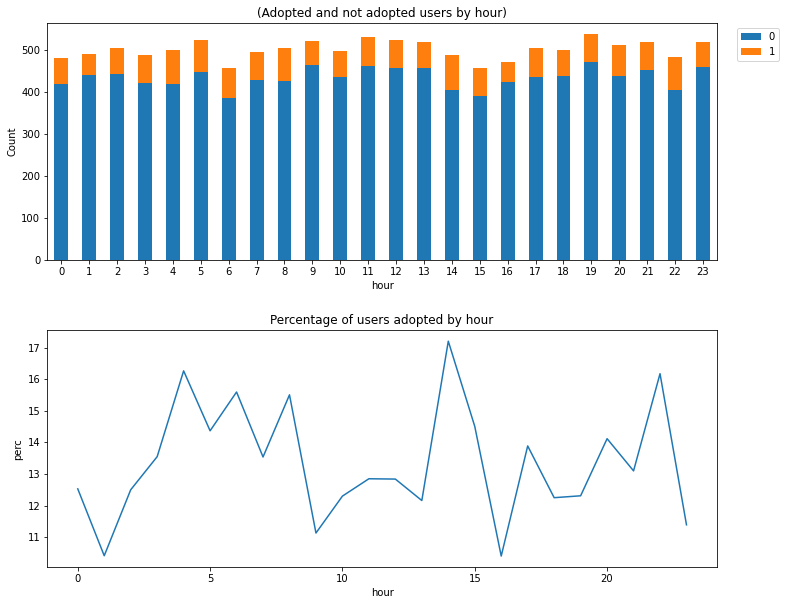

In [197]:
datetime_plot('hour', 'adopted', data=users_df)

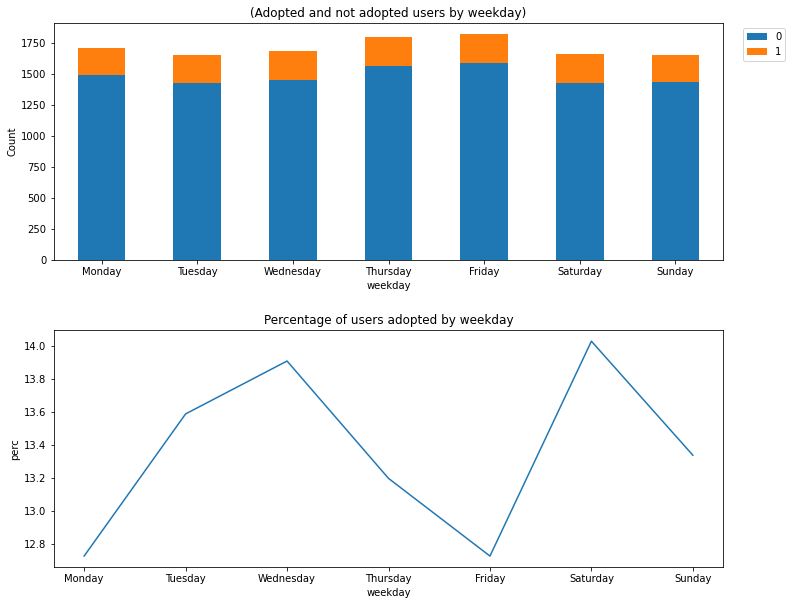

In [198]:
day_index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

datetime_plot('weekday', 'adopted', idx=day_index, data=users_df)

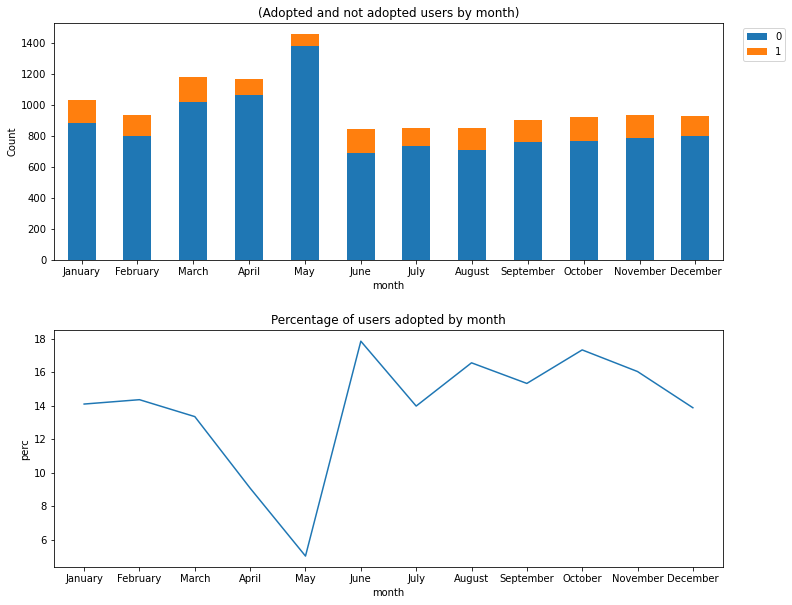

In [199]:
month_idx = ['January', 'February', 'March', 'April', 'May', 'June', 
           'July', 'August', 'September', 'October', 'November', 'December']

datetime_plot('month', 'adopted', idx=month_idx, data=users_df)

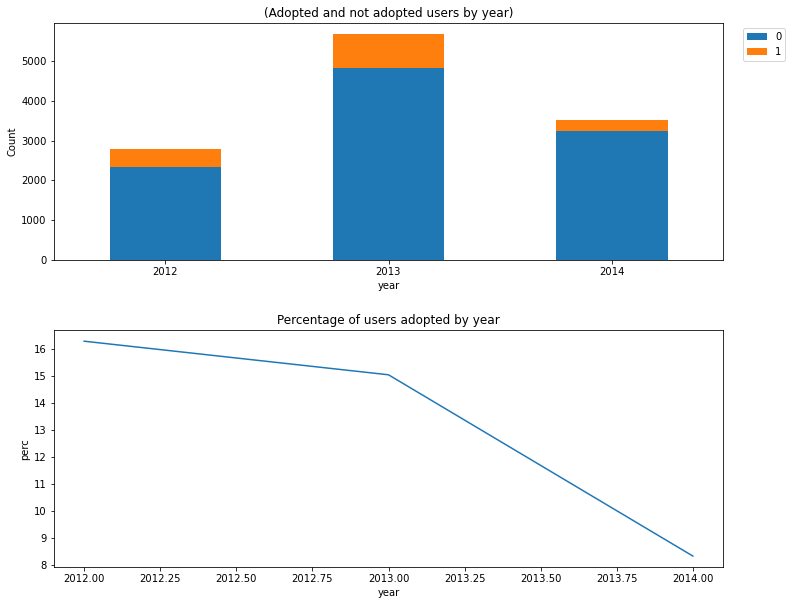

In [200]:
datetime_plot('year', 'adopted', data=users_df)

In [201]:
cat_cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']

In [220]:
def cat_bar(cols, y, data, figsize=(20,30)):
    """Plot bar graphs that: a) compare mean values of a target to different levels of a column
    b) compare different levels of a column to different levels of a target"""
    fig, axes = plt.subplots(len(cols),2, figsize=figsize)
    fig.subplots_adjust(wspace=0.3, hspace=0.5)
    
    for i, col in enumerate(cols):
        ax = axes.flatten()[i]
        
        plot1 = sns.barplot(x=col, y=y, data=data, ax=axes[i,0])
        plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45)
        plot1.set_title(f'Mean % adopted by {col}')
                
        df_plot = data.groupby([col, y]).size().reset_index().pivot(
            columns=y, index=col, values=0)
        df_plot.plot(kind='bar', stacked=True, ax=axes[i,1], rot=45)
        axes[i,1].set_title(f'Count by {col} separated by adoption status')

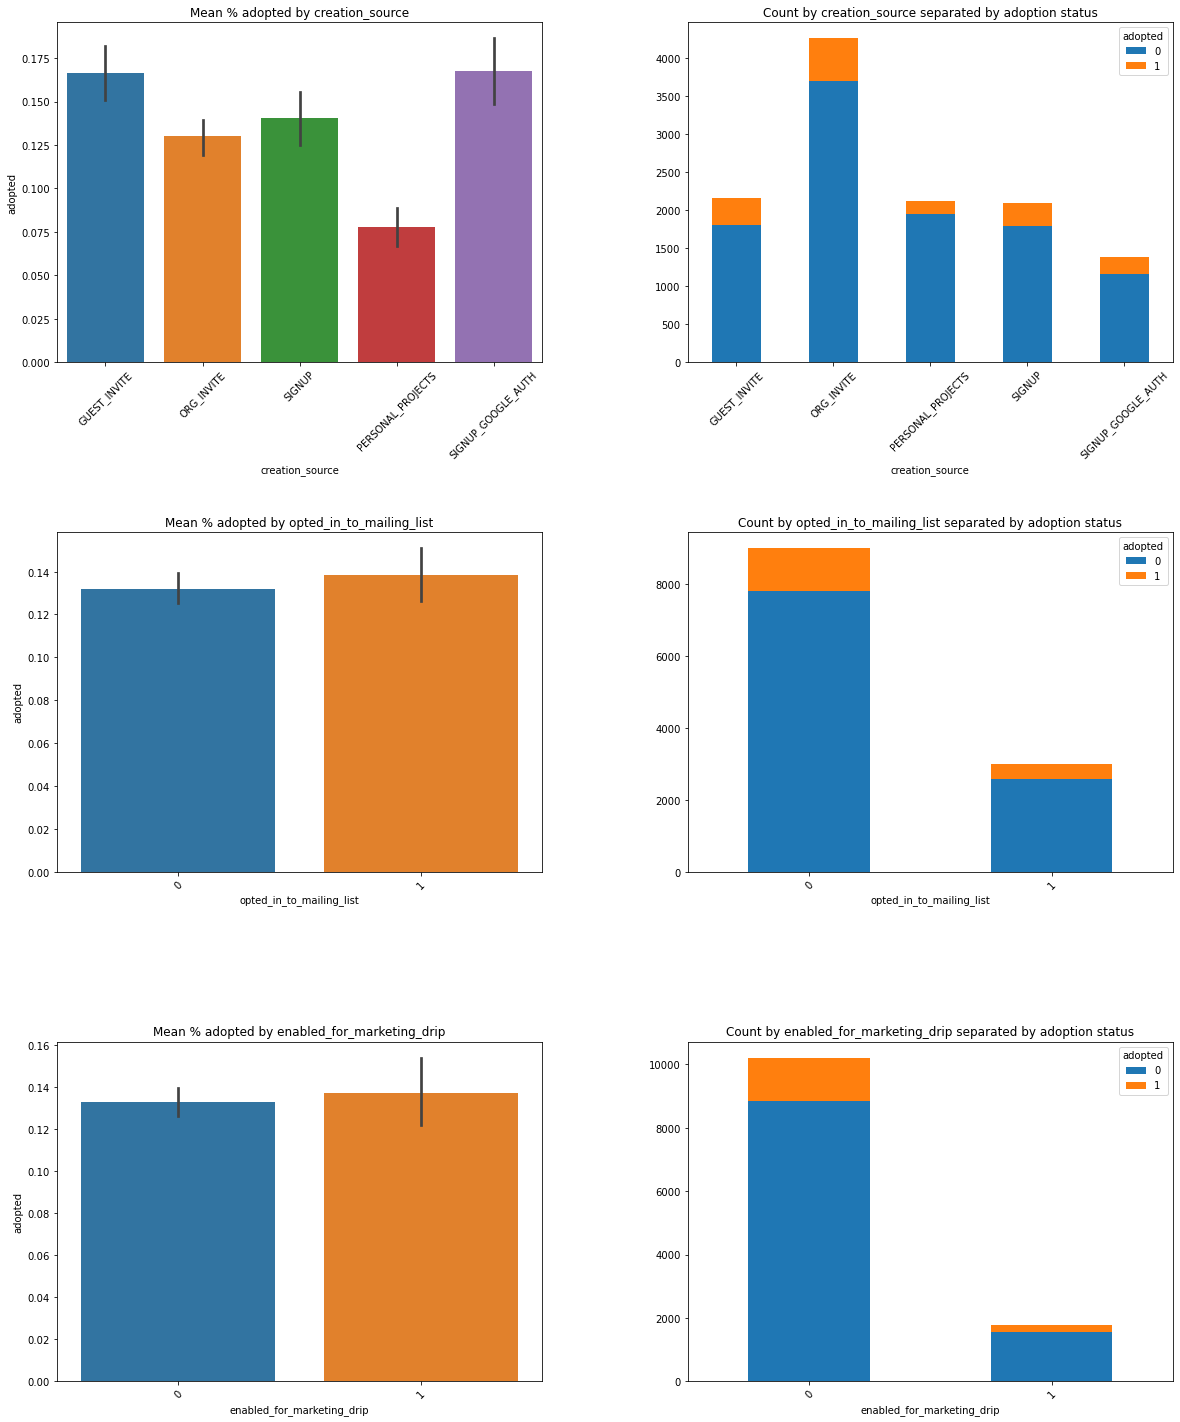

In [221]:
cat_bar(cat_cols, 'adopted', users_df, figsize=(20,25))

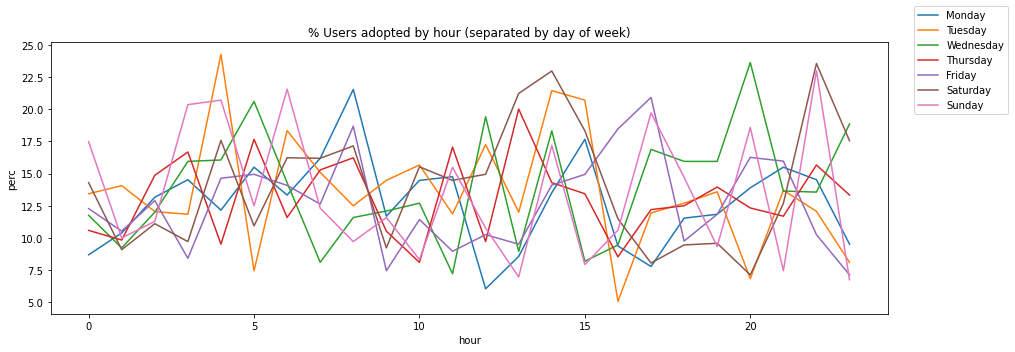

In [207]:
df_plot = users_df.groupby(['adopted', 'hour', 'weekday']).size().reset_index().pivot(
    columns='adopted', index=['hour', 'weekday'], values=0).reindex(day_index, level='weekday').reset_index()

df_plot['perc'] = round(df_plot[1]/(df_plot[0]+df_plot[1])*100, 2)

plt.figure(figsize=(15,5))
x = sns.lineplot(x='hour', y='perc', data=df_plot, hue='weekday');
x.set_title('% Users adopted by hour (separated by day of week)');
x.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15));

There doesn't seem to be a consistent hourly pattern between days of the week.

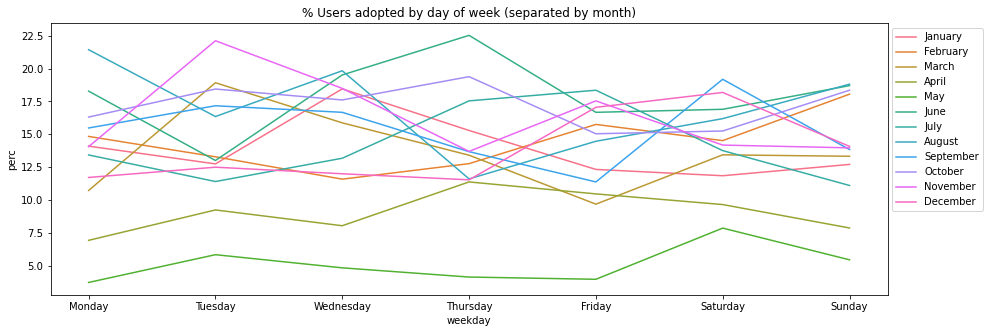

In [210]:
df_plot = users_df.groupby(['adopted', 'weekday', 'month']).size().reset_index().pivot(
    columns='adopted', index=['weekday', 'month'], values=0).reindex(day_index, level='weekday').reindex(
    month_idx, level='month').reset_index()

df_plot['perc'] = round(df_plot[1]/(df_plot[0]+df_plot[1])*100, 2)

plt.figure(figsize=(15,5))
x = sns.lineplot(x='weekday', y='perc', data=df_plot, hue='month');
x.set_title('% Users adopted by day of week (separated by month)');
x.legend(loc='upper right', bbox_to_anchor=(1.12, 1));

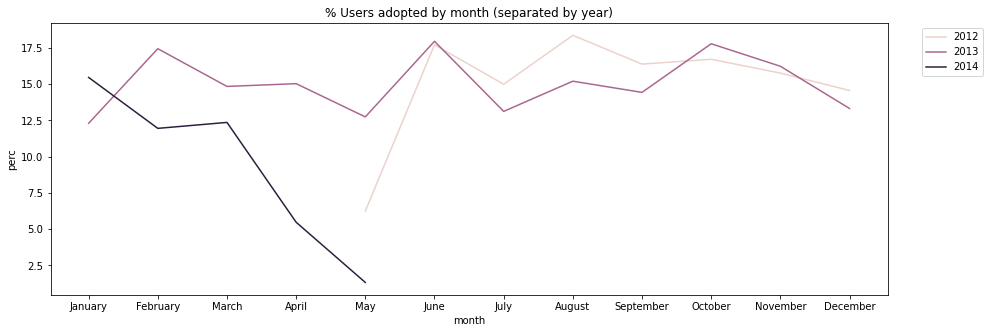

In [242]:
df_plot = users_df.groupby(['adopted', 'month', 'year']).size().reset_index().pivot(
    columns='adopted', index=['month', 'year'], values=0).reindex(month_idx, level='month').reset_index()

df_plot['perc'] = round(df_plot[1]/(df_plot[0]+df_plot[1])*100, 2)

plt.figure(figsize=(15,5))
x = sns.lineplot(x='month', y='perc', data=df_plot, hue='year');
x.set_title('% Users adopted by month (separated by year)');
x.legend(loc='upper right', bbox_to_anchor=(1.12, 1));

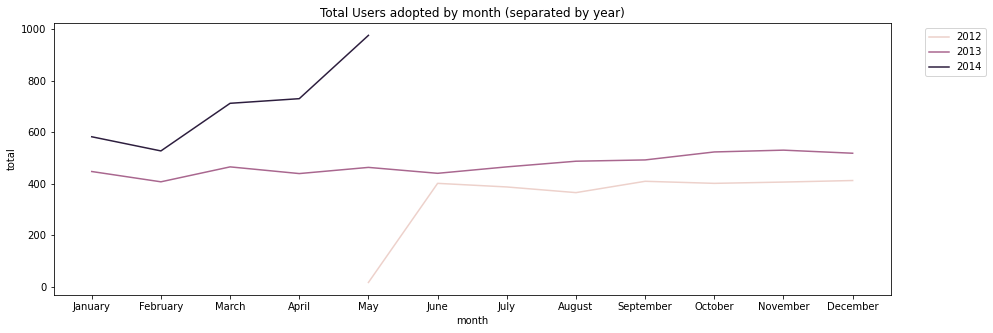

In [245]:
df_plot = users_df.groupby(['adopted', 'month', 'year']).size().reset_index().pivot(
    columns='adopted', index=['month', 'year'], values=0).reindex(month_idx, level='month').reset_index()
df_plot['total'] = df_plot[1]+df_plot[0]

plt.figure(figsize=(15,5))
x = sns.lineplot(x='month', y='total', data=df_plot, hue='year');
x.set_title('Total Users adopted by month (separated by year)');
x.legend(loc='upper right', bbox_to_anchor=(1.12, 1));